# Travail Pratique de Machine Learning pour l'octroi de crédit

## Introduction

Dans cette situation, le défi réside dans la mise en place d'une approche modernisée de Big Data/IA pour la prédiction d'octroi de crédit au sein d'une banque. Le responsable de la ligne de produit crédit à la consommation souhaite prendre des décisions éclairées sur l'attribution des crédits en se basant sur des données antérieures.

La banque dispose d'un ensemble de données comprenant plus de 18 500 crédits, chacun caractérisé par un indicateur et 41 paramètres. L'indicateur, figurant dans la colonne "indicatrice" du fichier de données, distingue les crédits bien remboursés des problématiques (1 indique un problème sur le crédit).

Sur le plan financier, la banque réalise un gain de 4 000 € par crédit bien remboursé, mais subit une perte moyenne de 13 000 € par crédit problématique.

La mission consiste à élaborer une solution Data, accompagnée d'un mode d'emploi, répondant à la demande du responsable de la ligne produit. L'objectif final est d'optimiser l'espérance de bénéfice de la banque dans le processus d'octroi de crédit.

In [1]:
import pandas as pd
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score, roc_auc_score, accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
IMG_DIR_PATH = 'img'
DATA_DIR_PATH = 'data'

CSV_FILE = os.path.join(DATA_DIR_PATH,'Data_Finance_TrainEtVal_13Nov23.csv')


## Chargement des données

Le Dataset avec lequel nous travaillons se présente sous la forme d'un fichier csv que nous allons charger en dataframe pandas.

In [2]:
df = pd.read_csv(CSV_FILE,sep=';')
df.head()

,Id,GENR,produit,age du bien,mode de paiement,montant demande (centimes),delai paiement,apport,apport %,date demande,...,impayes,charge,fichage3,revenus,secteur activite,code postal,Chiffre d'affaires,Capital social,Indicatrice,Label
0,4212339,VP,LLD,0,10,4967310,10,0,0.0,04/01/2010 09:59,...,0,0,0,0,77,95100,0,200000,0,Train
1,4212408,VP,CB,0,10,1228763,0,245753,20.0,04/01/2010 10:58,...,0,0,0,100000,41,93600,0,750000,0,Train
2,4212504,VU,CB,0,10,1262250,0,189338,15.0,04/01/2010 12:44,...,0,0,0,100000,43,47130,0,500000,0,Train
3,4212509,,LLD,0,10,1500000,10,0,0.0,04/01/2010 13:19,...,0,0,0,400000,66,67500,0,1000000,0,Train
4,4212561,VU,LLD,0,10,2393850,10,0,0.0,04/01/2010 14:43,...,0,0,0,300000,49,60110,0,750000,0,Train


Le dataset chargé, nous pouvons désormais avoir une vue d'ensemble des données à prédire correctement à savoir le label `Indicatrice` qui renseigne sur l'état du remboursement d'un client. Nous allons faire un simple plot de la répartition des `Indicatrice`s.

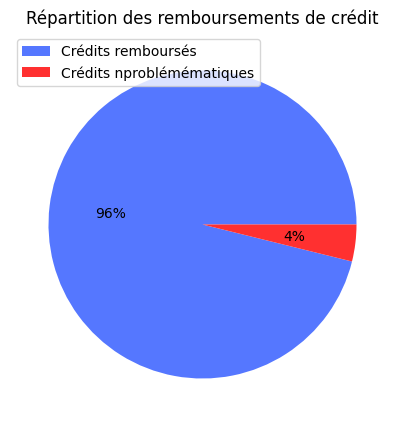

In [3]:

val_counts = df['Indicatrice'].value_counts()
val_counts.index = ['Crédits remboursés', 'Crédits nproblémématiques']
fig = plt.figure(figsize=(5, 5))

ax = fig.add_subplot(111)
ax.pie(val_counts, autopct='%1.0f%%', colors=["#5577FF", "#FF3030"])
ax.set_title('Répartition des remboursements de crédit')
ax.legend(val_counts.index, loc='upper left')
fig.savefig(os.path.join(IMG_DIR_PATH,'pie_chart.png'), dpi=300)
plt.show()

Nous remarquons clairement que les prêts avec défaut de remboursement sont très minimes sur l'ensemble du dataset, il faudra donc faire en sorte d'élaborer des modèles qui seront capable d'évaluer avec précision l'état d'un remboursement.

## Nettoyage des données

Avant de traiter la donnée, il faut être en mesure de la manipuler. Pour ce faire il faut la *'nettoyer'* afin de la rendre utilisable.

### Typage adéquat des valeurs du dataset.

Le but ici est d'avoir une homogénéité entre le type réel des données et les types pandas (`dtype`).

In [4]:
for col in df.columns:
  if(df[col].apply(pd.to_numeric, errors='coerce').notna().all()):
    df[col] = (df[col].apply(pd.to_numeric, errors='coerce'))

### Numérisation de certaines valeurs catégoriques

La plupart des modèles prennent en entrée des valeurs numériques, afin d'enrichir nos données d'entrée nous allons nous permettre d'encoder certaines valeurs de type `object` (des chaines de caractères) sous forme d'entiers. Mais d'abord cherchons les données catégoriques avec un nombre de valeurs uniques inférieur à 10. 

In [103]:
column_with_yes_or_no = []
print('Valeurs catégorielles avec moins de 10 valeurs uniques : ')
print(7*'-')
for col in df.columns:
  unique_values = df[col].unique()
  if(df[col].dtype == 'object' ):
    if(len(unique_values) < 15):
      print(col, unique_values)
    if('N' in unique_values and 'O' in unique_values):
      column_with_yes_or_no.append(col)


Valeurs catégorielles avec moins de 10 valeurs uniques : 
-------
GENR ['VP' 'VU' ' ']
produit ['LLD' 'CB' 'CC' 'TP']
cotation ['X0' 'ZZZZZZ' 'X7' 'X5' 'X8' 'X5+' '0' 'L0' 'X9' 'X6' 'K0' 'XP']
alerte fraude ['N' 'O']
Connu ['N' 'O']
fichage ['N' 'O' ' ']
incapacite [' ' 'N' 'O']
segmentation [nan ' ' 'S' 'E' '4' '5' '2' '3' '6' '1']
procédure collective BdF ['N' 'O']
procédure collective ORT ['N' 'O']
contentieux ['N' 'H' 'O']
cotation dirigeant ['0' '40' 'ZZZZZZ' ' ' '60' '50']
fichage1 ['N' 'O' ' ']
dirigeant client ['N' 'O']
fichage2 ['N' 'O' ' ']
Label ['Train' 'Validation']


In [32]:
# Print numerical columns
print('Valeurs numériques : ')
print(7*'-')
for col in df.columns:
  if(df[col].dtype != 'object' and col != 'Indicatrice'):
    print(col)

Valeurs numériques : 
-------
Id
age du bien
mode de paiement
montant demande (centimes)
delai paiement
apport
apport %
duree
existence impaye regularise
presence homonyme
Montant
effets impayes
montant impayes internes
age dirigeant
impayes
charge
fichage3
revenus
Chiffre d'affaires
Capital social


Nous remarquons que le dataset possède beaucoup de valeurs littérales qui peuvent être interprétées comme booléenes (colonne oui ou non). Nous allons donc les garder pour les convertir en entier. 

In [33]:

print('Colonnes avec des valeurs oui/non : ')
for col in column_with_yes_or_no:
  print(f'- {col}')

Colonnes avec des valeurs oui/non : 
- alerte fraude
- Connu
- fichage
- incapacite
- procédure collective BdF
- procédure collective ORT
- contentieux
- fichage1
- dirigeant client
- fichage2


A partir des colonnes susmentionnées, nous allons ici convertir toutes les valeurs positives (`'O'`)à 1 et 0 pour `'N'` ou en cas d'absence de donnée.

In [34]:
clean_df = df.copy()

for col in column_with_yes_or_no:
  clean_df[col] = clean_df[col].apply(lambda x: 1 if x == 'O' else 0).astype('int64')

Nous gardons ensuite les données catégoriques nécessaires telles que `'GENR'` ou `'produit'` et retirer les colonnes qui ne sont d'aucune utilité pour nos modèle telles que :
- `'Id'` l'identifiant du client
- '`apport %`' cette donnée est redondante étant donné que l'apport est déjà présent dans la colonne `'apport'`.
- `'date demande'` que nous supposons comme n'ayant aucune causalité sur le remboursement d'un prêt.

In [35]:

categorical_columns_to_keep = ['GENR','produit']
clean_df['Label'] = clean_df['Label'].apply(lambda x: 1 if x == 'Train' else 0).astype('int64')
important_numerical = [col for col in clean_df.columns if clean_df[col].dtype != 'object' and col not in column_with_yes_or_no]
important_numerical.remove('Id')
important_numerical.remove('apport %')
important_numerical.remove('Label')
important_numerical.remove('Indicatrice')
important_numerical.remove('presence homonyme')
column_with_yes_or_no.remove('procédure collective BdF')
column_with_yes_or_no.remove('procédure collective ORT')
clean_df = clean_df[column_with_yes_or_no+important_numerical+categorical_columns_to_keep + ['Label'] + ['Indicatrice']]

print('Colonnes du jeu de données nettoyé : ')
for i,col in enumerate(clean_df.columns,1):
  end = ' | ' if i%5 != 0 else '\n'
  print(f'{col}', end=end)
  

Colonnes du jeu de données nettoyé : 
alerte fraude | Connu | fichage | incapacite | contentieux
fichage1 | dirigeant client | fichage2 | age du bien | mode de paiement
montant demande (centimes) | delai paiement | apport | duree | existence impaye regularise
Montant | effets impayes | montant impayes internes | age dirigeant | impayes
charge | fichage3 | revenus | Chiffre d'affaires | Capital social
GENR | produit | Label | Indicatrice | 

Nous avons gardé les données catégoriques suivantes:

In [36]:
clean_df.to_csv(os.path.join(DATA_DIR_PATH,'data_clean.csv'),index=False)
clean_categorical_columns = [col for col in clean_df.columns if clean_df[col].dtype == 'object']
clean_categorical_columns

['GENR', 'produit']

In [42]:
def get_train_test(dataframe, categoricals:list[str] = None,one_hot:bool=False,split=False) -> tuple:
    if(one_hot and categoricals is not None):
        df_to_treat = pd.get_dummies(dataframe, columns=categoricals)
    else:
        label_encoded_df = dataframe.copy()

        label_encoder = LabelEncoder()

        # Appliquer le Label Encoding colonne par colonne
        for column in label_encoded_df.select_dtypes(include=['object']).columns:
            label_encoded_df[column] = label_encoder.fit_transform(label_encoded_df[column])

        df_to_treat = label_encoded_df.copy()
    if(not split):
        return df_to_treat
    X_train = df_to_treat[df_to_treat['Label'] == 1].drop(['Label','Indicatrice'], axis=1)
    X_test = df_to_treat[df_to_treat['Label'] == 0].drop(['Label','Indicatrice'], axis=1)
    y_train = df_to_treat[df_to_treat['Label'] == 1]['Indicatrice']
    y_test = df_to_treat[df_to_treat['Label'] == 0]['Indicatrice']
    return (X_train, X_test, y_train, y_test)


## Création de modèles
### Première apporche avec **XGBoost**

Afin de pouvoir avoir des rendus sur l'efficacicité de nos modèles nous allons implémenter les fonctions `plot_conf_mat` et `plot_roc_curve`.

In [12]:
def plot_conf_mat(y_test,y_pred,ax=None,title='Titre'):
  if(ax is None):
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111)
  confusion_mat =confusion_matrix(y_test, y_pred)
  confusion_mat = confusion_mat.astype('float') / confusion_mat.sum(axis=1)[:, np.newaxis]
  sns.heatmap(confusion_mat, annot=True, ax=ax,cmap='Blues',fmt='.2f',xticklabels=['Prédit 0','Prédit 1'],yticklabels=['Actual 0','Actual 1'])
  ax.set_ylabel('Label réel')
  ax.set_xlabel('Label prédit')
  ax.set_title(title)
  return ax

In [13]:
def plot_roc_curve(y_test,y_pred,ax=None,title='Titre',label=None):
  if(ax is None):
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111)
  fpr, tpr, thresholds = roc_curve(y_test, y_pred)
  ax.plot(fpr, tpr, label=label,color='blue')
  ax.plot([0, 1], [0, 1], linestyle='--', label='No Skill',color='red')
  ax.set_xlabel('False Positive Rate')
  ax.set_ylabel('True Positive Rate')
  ax.set_title(title + f' Roc Auc Score : {roc_auc_score(y_test,y_pred):.2f} ')
  ax.legend()
  return ax

#### Entraînement du modèle
Nous allons donc entrainer notre classificateur XGB en prenant en compte le déséquilibre des classes avec `scale_pos_weight`.

In [14]:
X_train, X_test, y_train, y_test = get_train_test(clean_df,clean_categorical_columns,one_hot=True)

scale_pos_weight = y_train.value_counts()[0]/y_train.value_counts()[1]
parameters = {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 200, 'scale_pos_weight': scale_pos_weight}
xgb_model = xgb.XGBClassifier(**parameters)
xgb_model.fit((X_train), y_train);


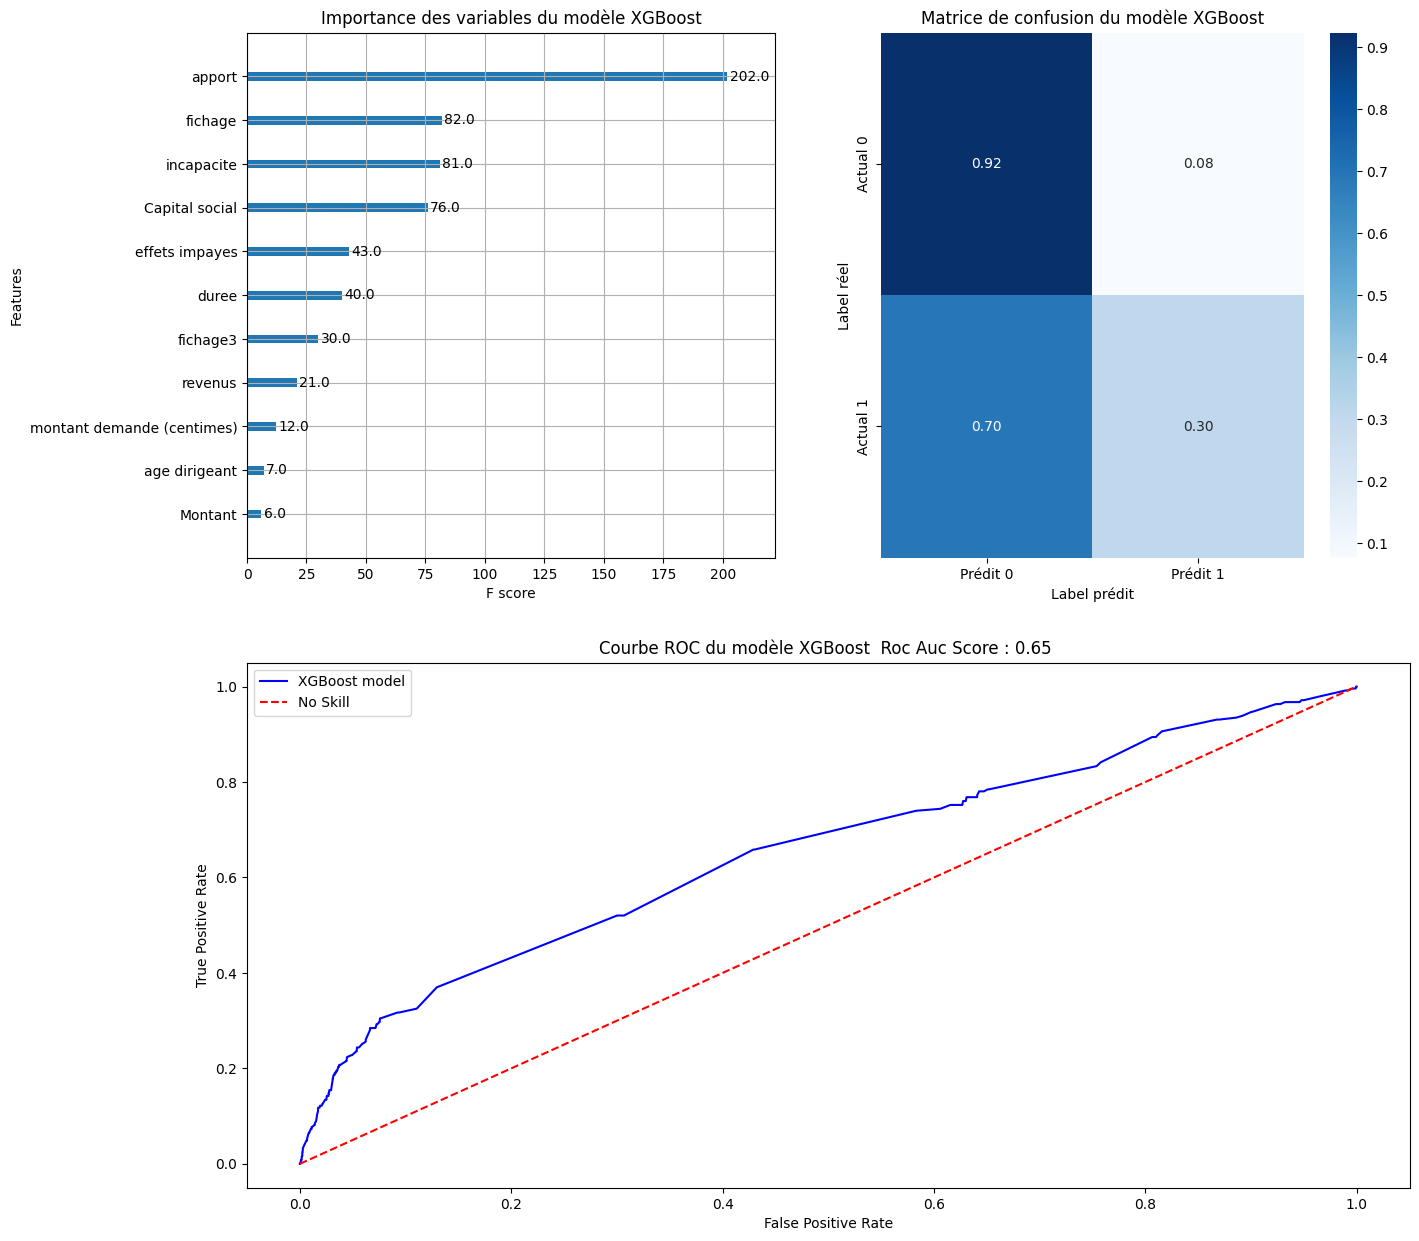

In [15]:
from xgboost import plot_importance

y_pred = xgb_model.predict((X_test))
# plot feature importance

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(2, 2, 1)
plot_importance(xgb_model,ax=ax,title='Importance des variables du modèle XGBoost')
# plot confusion matrix

confusion_mat =confusion_matrix(y_test, y_pred)
confusion_mat = confusion_mat.astype('float') / confusion_mat.sum(axis=1)[:, np.newaxis]
ax = fig.add_subplot(2, 2, 2)
plot_conf_mat(y_test,y_pred,ax=ax,title='Matrice de confusion du modèle XGBoost')
# plot roc curve
y_pred_proba = xgb_model.predict_proba(X_test)[:,1]
plot_roc_curve(y_test,y_pred_proba,ax=fig.add_subplot(2, 1, 2),title=f'Courbe ROC du modèle XGBoost ',label=f'XGBoost model')
fig.savefig(os.path.join(IMG_DIR_PATH,'xgboost_model.png'), dpi=300)
plt.show()



On observe que notre classificateur n'est pas efficace pour détecter les remboursements problématiques car sur l'ensemble des données problématiques il n'arrive qu'à en détecter 30%. Concernant la courbe ROC nous obtenons 0.65 ce qui n'est pas suffisant pour la bonne détection. 

Une telle inefficacité peut s'expliquer par le fait que le modèle et ses hyperparamètres ne sont pas adaptés pour le problème. Une autre explication pourrait être également le fait que les classes sont déséquilibrées et que par conséquent l'algorithme a du mal à s'entrainer et identifier les remboursements problématiques.

D'un point de vue métier cherchons à calculer les gains enengendrés par l'utilisation d'un tel modèle.

In [98]:
from sklearn.metrics import roc_curve, auc

def compute_gains(model,X_test,y_test):
    gain_per_good = 4000
    gain_per_bad = -13000
    y_true = np.array(y_test)
    gain = (1-y_true)*gain_per_good + (y_true)*gain_per_bad
    gain = np.array(gain)
    pred = model.predict_proba(X_test)[:,1]
    auc = roc_auc_score(y_true, pred)
    pred = (pred > auc).astype(int)
    y_true = y_true
    new_gain = np.zeros(len(gain))
    new_gain[(pred==0) & (y_true==0)] = gain_per_good
    new_gain[(pred==0) & (y_true==1)] = gain_per_bad
    print(f'Bonnes prédictions : {np.sum((pred == y_true))}')
    print(f'Gains après application du modèle : {np.sum(new_gain)}')
    print(f'Gain relatif : {(np.sum(new_gain) - np.sum(gain))/np.sum(gain)*100:.2f}%')
    

In [99]:
compute_gains(xgb_model,X_test,y_test)

Bonnes prédictions : 6325
Gains après application du modèle : 22426000.0
Gain relatif : -1.06%


On peut remarquer effectivement que lorsque nous appliquons notre modèle aux données il n'est clairement pas adaptéspuisque sur les données test il engendre des pertes de 1.06%

### Deuxième approche avec `DecisionTreeClassifier`

              precision    recall  f1-score   support

           0       0.98      0.59      0.74      6466
           1       0.06      0.63      0.10       246

    accuracy                           0.59      6712
   macro avg       0.52      0.61      0.42      6712
weighted avg       0.94      0.59      0.71      6712



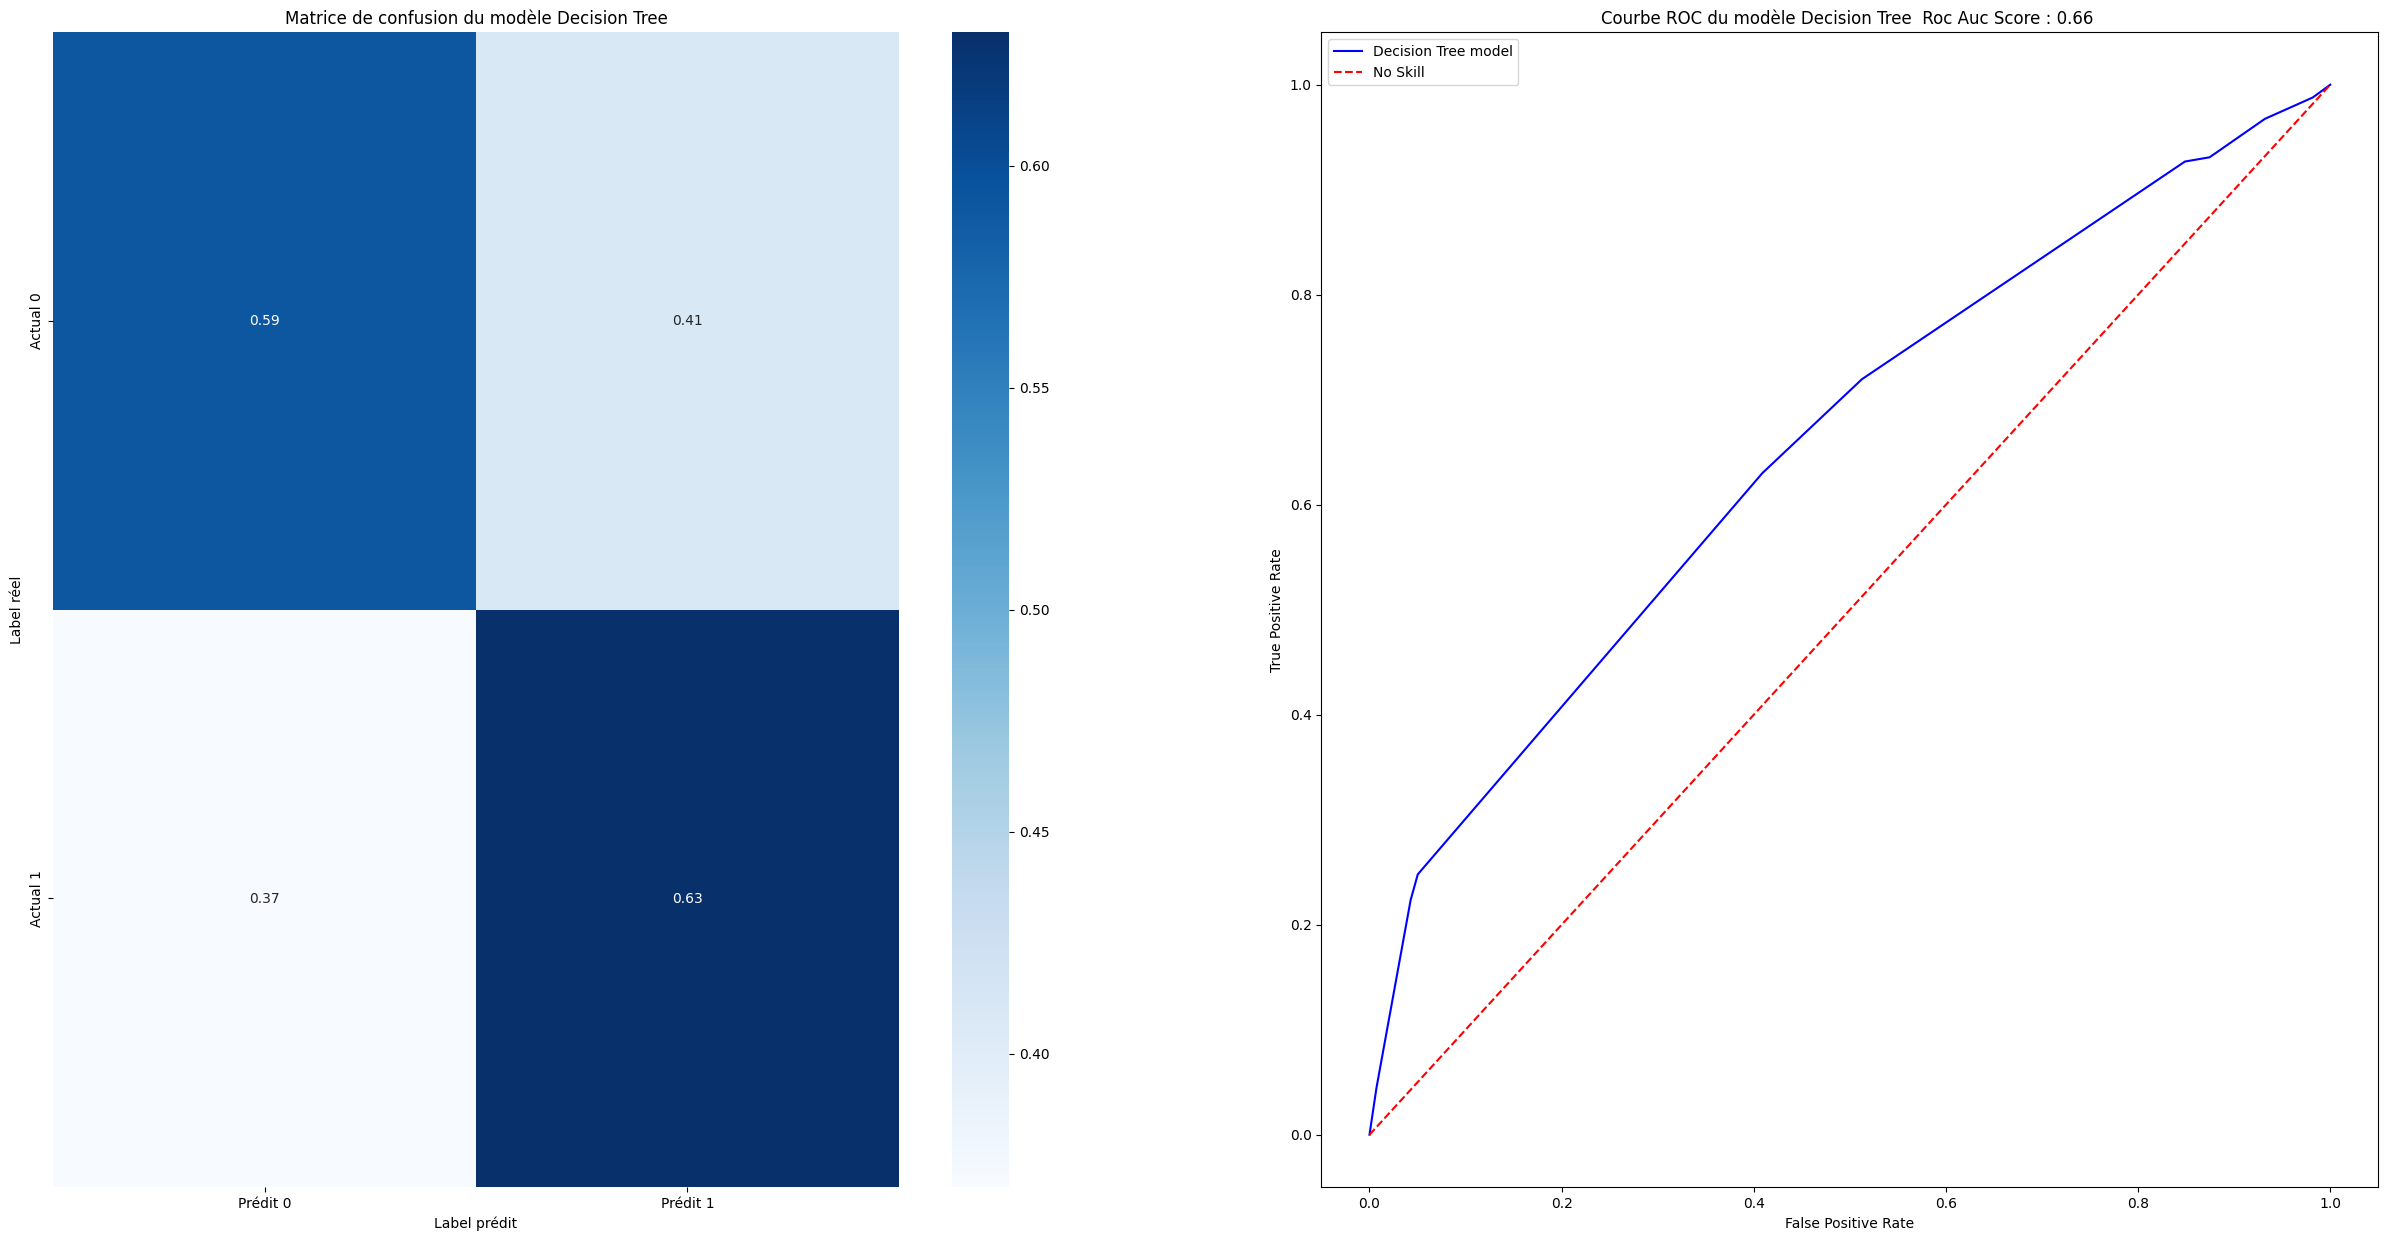

In [81]:
from sklearn.tree import DecisionTreeClassifier

parameters = {'max_depth': 5,'min_samples_split': 0.1,'class_weight': 'balanced'}
# make parameters grid for grid search
parameters_grid = {'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],'min_samples_split': [0.1, 0.2,0.9],'class_weight': ['balanced', None]}
# make scorer
scorer = make_scorer(roc_auc_score)
# make grid search
grid_obj = GridSearchCV(DecisionTreeClassifier(), parameters_grid, scoring=scorer)
# fit grid search
grid_fit = grid_obj.fit(X_train, y_train)
# get best estimator
dt_model = grid_fit.best_estimator_


dt_model = DecisionTreeClassifier(**parameters)
dt_model.fit((X_train), y_train)
# classifcation report
y_pred = dt_model.predict((X_test))
print(classification_report(y_test, y_pred))
# plot confusion matrix and roc curve
fig = plt.figure(figsize=(30, 15))
ax = fig.add_subplot(1, 2, 1)
plot_conf_mat(y_test,y_pred,ax=ax,title='Matrice de confusion du modèle Decision Tree')
y_pred_proba = dt_model.predict_proba(X_test)[:,1]
plot_roc_curve(y_test,y_pred_proba,ax=fig.add_subplot(1, 2, 2),title=f'Courbe ROC du modèle Decision Tree ',label=f'Decision Tree model')
fig.savefig(os.path.join(IMG_DIR_PATH,'decision_tree_model.png'), dpi=300)


On observe dans le cas du `DecisionTreeClassifier` qu'il détecte mieux les prêts défaillants que le modèle précédant. Cependant il est beaucoup plus biaisé quant à la détection des prêts non problématiques. Le score ROC ne change pas non plus significativement par rapport au modèle précédent. On peut expliquer une telle inefficacité par le fait que les données ne sont pas bien équilibrées. 

In [100]:
compute_gains(dt_model,X_test,y_test)

Bonnes prédictions : 6202
Gains après application du modèle : 22159000.0
Gain relatif : -2.24%


Encore une fois, on peut remarquer effectivement que lorsque nous appliquons notre modèle aux données il n'est clairement pas adaptéspuisque sur les données test il engendre des pertes de 2.24%

En conclusion des deux modèles créés précédemment il ne sont clairement pas adaptés pour la détection de prêts défaillants en raison du déséquilbre de classe qui est biaise leur efficacité.

### Tentative de résolution du problème de déséquilibre

Nous allons chercher à gérer le problème du déséquilbre avec la classe `BalancedBaggingClassifier`.

Poids de la classe positive : 0.9602677058624195


/home/bast7594/.local/lib/python3.10/site-packages/imblearn/ensemble/_bagging.py:362: FutureWarning: `base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
  warnings.warn(


Bonnes prédictions : 6275
Gains après application du modèle : 22406000.0
Gain relatif : -1.15%


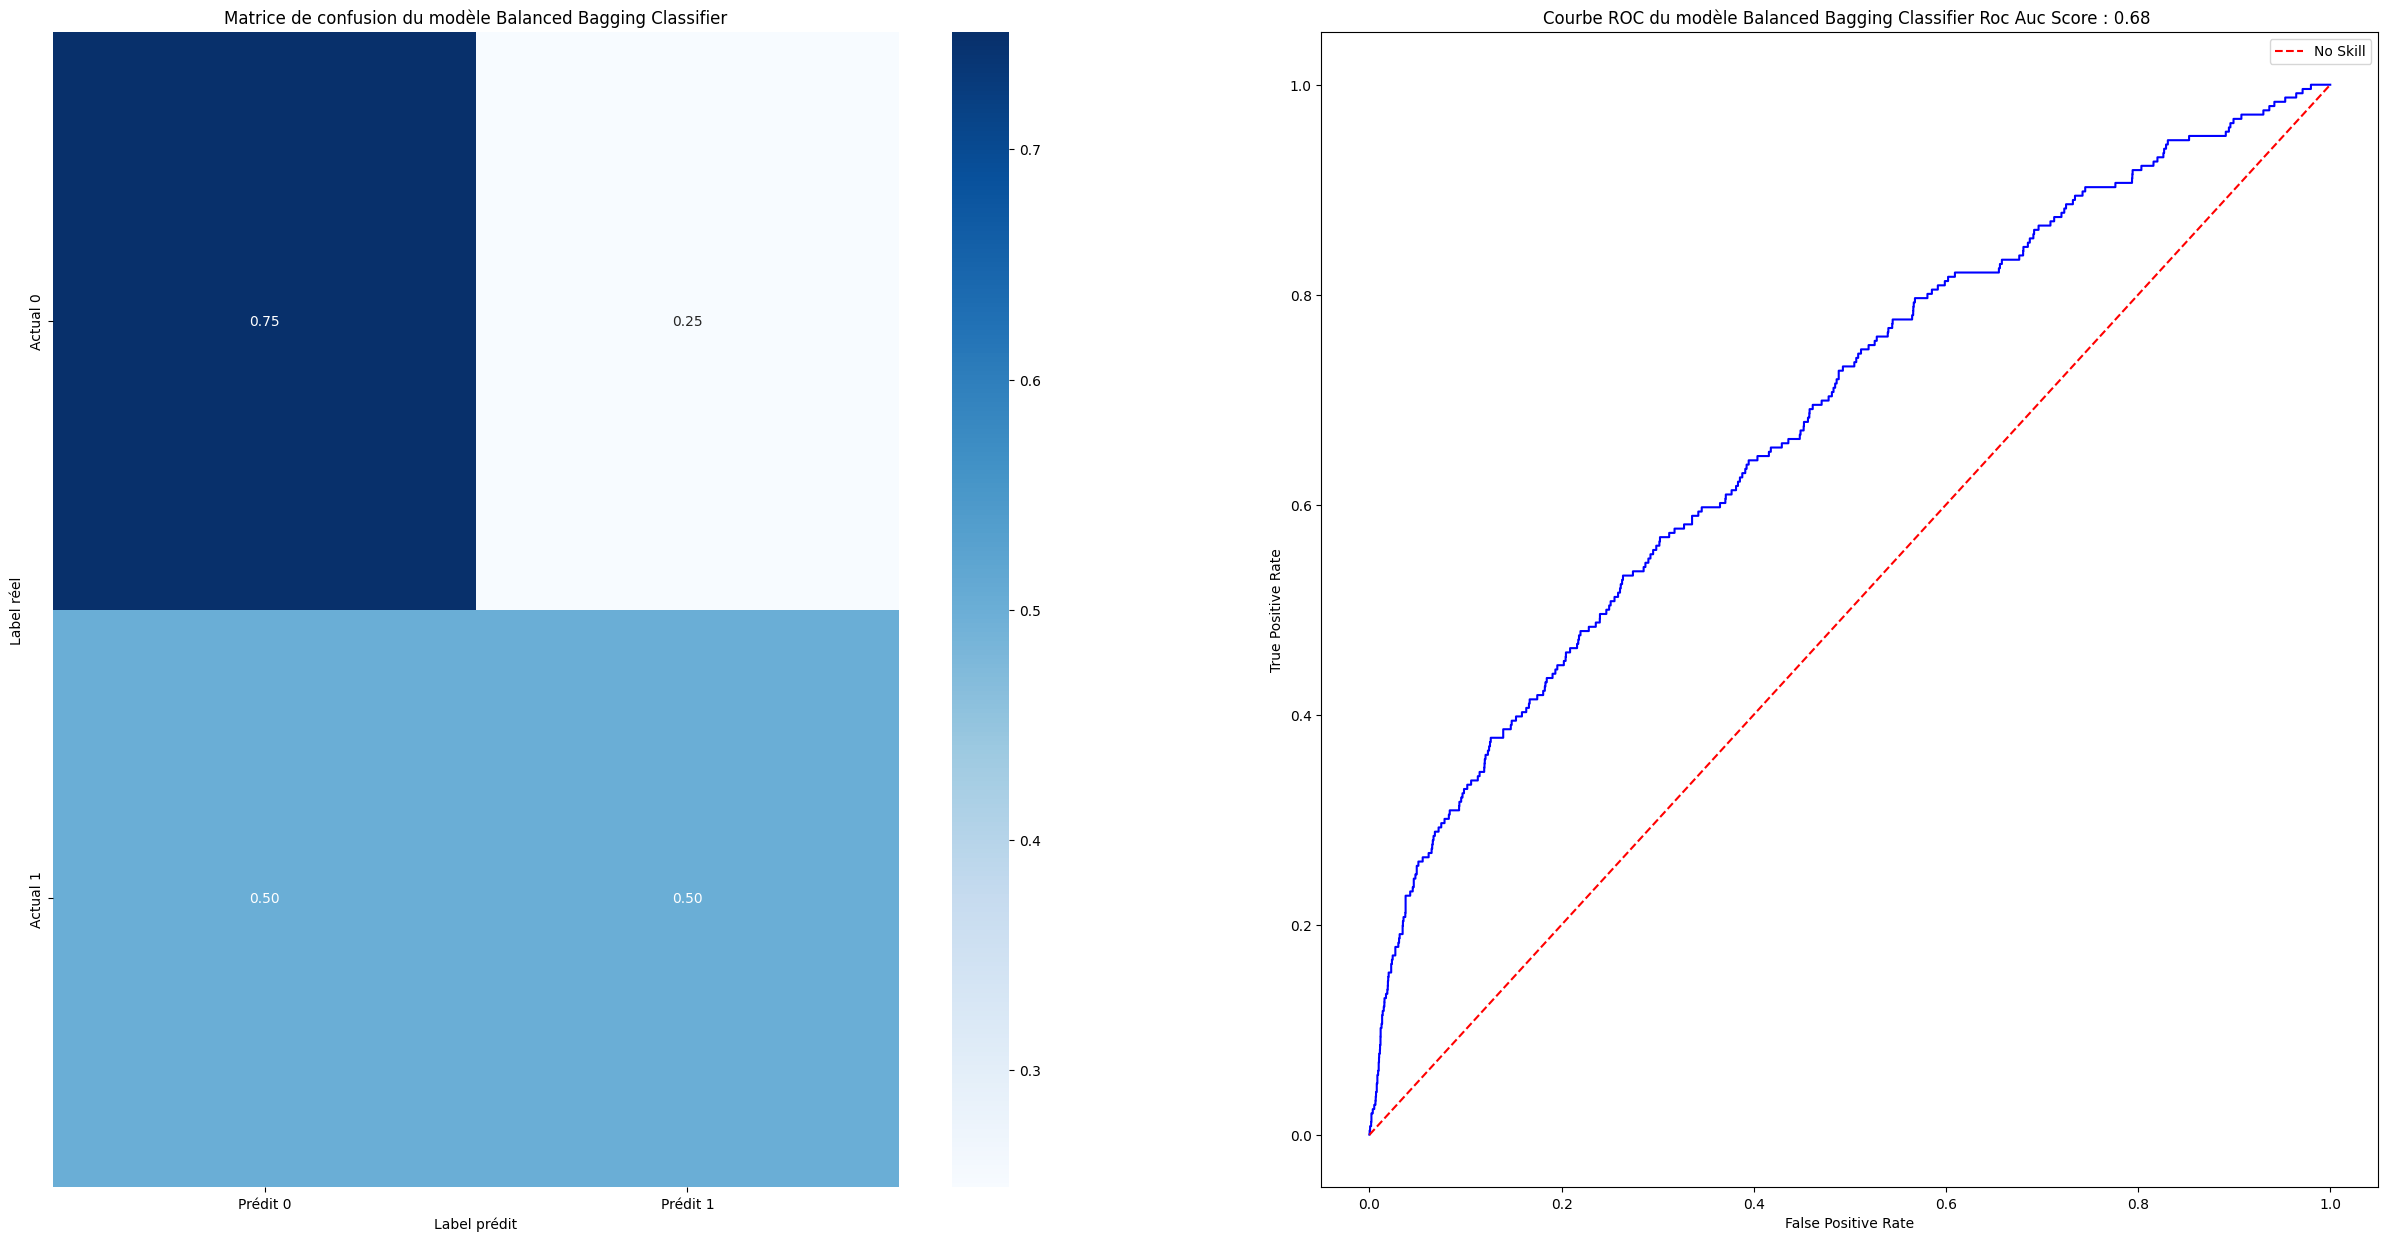

In [125]:
from imblearn.ensemble import BalancedBaggingClassifier
X_train, X_test, y_train, y_test = get_train_test(clean_df,clean_categorical_columns,split=True)
scale_pos_weight = y_train.value_counts()[0]/len(y_train)
print(f'Poids de la classe positive : {scale_pos_weight}')
xgb_model = xgb.XGBClassifier(learning_rate=0.2, max_depth=2, n_estimators=200, random_state=42,scale_pos_weight=scale_pos_weight)
bbc = BalancedBaggingClassifier(base_estimator=xgb_model,sampling_strategy='auto',replacement=True,random_state=0)
bbc.fit(X_train, y_train)
fig = plt.figure(figsize=(30, 15))
ax = fig.add_subplot(1, 2, 1)
plot_conf_mat(y_test,bbc.predict(X_test),title='Matrice de confusion du modèle Balanced Bagging Classifier',ax=ax)
ax = fig.add_subplot(1, 2, 2)
plot_roc_curve(y_test,bbc.predict_proba(X_test)[:,1],title='Courbe ROC du modèle Balanced Bagging Classifier',ax=ax)
compute_gains(bbc,X_test,y_test)

On peut remarquer après application de `BalancedBaggingClassifier` sur un classificateur `XGBoost` le score AUC s'améliore quelque peu, cependant les pertes enengendrées par l'utilisation du modèle sont toujours présentes.